In [1]:
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import pingouin as pg
import seaborn as sns

In [22]:
t1 = pd.read_csv('5_task_1.csv')
t2 = pd.read_csv('5_task_2.csv')

•	В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные   
•	Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый  
  
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

•	id – id клиента в эксперименте  
•	group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
•	events – сколько блюд суммарно было заказано за период  

In [5]:
t1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


•	id – id клиента в эксперименте  
•	segment – сегмент (high/low)  
•	group – вид кнопки (control – старая версия, test – новая версия)  
•	events – сколько блюд суммарно было заказано за период  

In [6]:
t2.head()   

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [7]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.3+ KB


In [8]:
t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [9]:
t1.describe()

,id,events
count,30000.000000,30000.000000
mean,14999.500000,31.554500
std,8660.398374,10.878761
min,0.000000,-7.000000
25%,7499.750000,24.000000
50%,14999.500000,31.000000
75%,22499.250000,39.000000
max,29999.000000,75.000000


In [10]:
t2.describe()

,id,events
count,100000.000000,100000.000000
mean,49999.500000,34.213930
std,28867.657797,17.585193
min,0.000000,4.000000
25%,24999.750000,21.000000
50%,49999.500000,29.000000
75%,74999.250000,40.000000
max,99999.000000,102.000000


1.	Выберите метод, который предположительно подойдет в первом вопросе.

<Axes: xlabel='group', ylabel='events'>

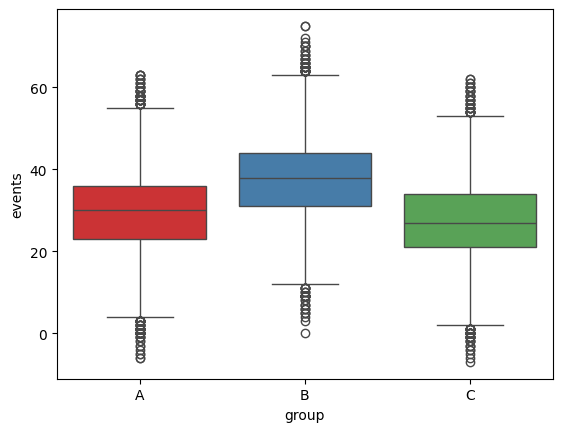

In [18]:
sns.boxplot(x="group", y="events", hue="group", data=t1, palette="Set1")

<Axes: xlabel='group', ylabel='events'>

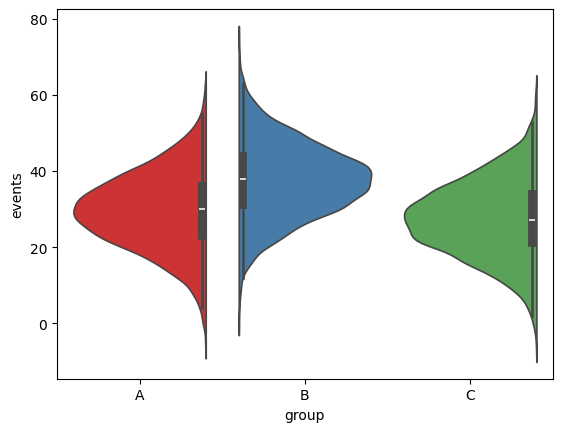

In [19]:
sns.violinplot(x="group", y="events", hue="group", data=t1, palette="Set1", split=True)

1. Каким статистическим методом нужно воспользоваться для сравнения вредних в данном случае?

In [ ]:
# t1 ANOVA оneway(однофакторный), т.к. независимая переменная - группа (3 уровня: A, B, C), зависимая - события (events)
pg.anova(dv='events', between='group', data=t1)
# ddof1 - число степеней свободы между группами (dfbetween​=k−1, где k - число групп)
# ddof2 - число степеней свободы внутри групп, ошибка, шум (dfwithin​=N−k, где N - общее число наблюдений)
# F - значение критерия Фишера. Различия между средним числом заказанных блюд в группах в ~2900 раз сильнее, чем случайный шум внутри групп. 
# F = межгрупповые различия/внутригрупповые различия. F=MSbetween/MSwithin (эти значения можно получить, если ввести detailed=True)
# p-unc - p-value без поправки
# np2 - эффект размера Пирсона (>0.14 - большой эффект, 0.06-0.14 - средний, <0.06 - малый). Около 16% всей вариации пользовательского поведения объясняется именно разрешением фотографий
# вывод: p<0.05, отвергаем H0, значит есть статистически значимые различия между группами, np2=0.16 - большой эффект размера

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена. 